In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys, os
sys.path.append('..')

import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from matplotlib import pyplot as plt

from get_data import get_data, get_splitted_data
from models.active_model import ActiveLearningExperiment
from models.strategy import *
from models.utils import ObstructedY

from misc.config import c
data_dir = c["DATA_DIR"]

In [3]:
loader = ["get_splitted_uniform_data",
                  {"n_folds": 1,
                   "seed":666,
                   "test_size":0.0}]

comp = [['5ht7', 'ExtFP']]
preprocess_fncs = []
folds, _, _ = get_data(comp, loader, preprocess_fncs).values()[0]

al_ecml2015: 2015-06-04 13:09:46,034 - Running preprocess on 0 fold
al_ecml2015: 2015-06-04 13:09:46,034 - Wasn't able to set write/read flags


In [4]:
X, y = folds[0]['X_train']['data'], folds[0]['Y_train']['data']
print X.shape
print y.shape

(1000, 2)
(1000,)


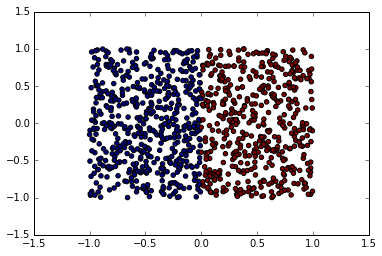

In [5]:
plt.scatter(X[:,0], X[:,1], c=y)

In [4]:
from experiments.experiment_runner import run_experiment, run_experiment_grid
from experiments import experiment_runner, fit_active_learning, fit_grid
from sklearn.svm import SVC
from experiments.utils import get_best

from kaggle_ninja import *
turn_on_force_reload_all()

grid_result_passive = run_experiment("fit_grid",
                                    recalculate_experiments=True,
                                    n_jobs = 8,
                                    experiment_detailed_name="fit_svm_passive_tiles",
                                    base_experiment="fit_active_learning",
                                    seed=666,
                                    grid_params = {"base_model_kwargs:C": list(np.logspace(-5,5,10)),
                                                   "base_model_kwargs:kernel": ['linear']},
                                    base_experiment_kwargs={"strategy": "random_query",
                                                       "loader_function": "get_splitted_uniform_data",
                                                       "batch_size": 20, \
                                                       "base_model": "SVC",
                                                       "loader_args": {"n_folds": 2}})

random_exp = get_best(grid_result_passive.experiments, "mean_wac_score_valid")
print random_exp

fit_grid: 2015-06-04 13:20:56,056 - Added new config entry: "base_experiment_kwargs.base_model"
fit_grid: 2015-06-04 13:20:56,056 - Added new config entry: "base_experiment_kwargs.batch_size"
fit_grid: 2015-06-04 13:20:56,057 - Added new config entry: "base_experiment_kwargs.loader_args"
fit_grid: 2015-06-04 13:20:56,057 - Added new config entry: "base_experiment_kwargs.loader_args.n_folds"
fit_grid: 2015-06-04 13:20:56,057 - Added new config entry: "base_experiment_kwargs.loader_function"
fit_grid: 2015-06-04 13:20:56,058 - Added new config entry: "base_experiment_kwargs.strategy"
fit_grid: 2015-06-04 13:20:56,058 - Added new config entry: "grid_params.base_model_kwargs:C"
fit_grid: 2015-06-04 13:20:56,058 - Added new config entry: "grid_params.base_model_kwargs:kernel"
fit_grid: 2015-06-04 13:20:56,059 - Running command 'main'
fit_grid: 2015-06-04 13:20:56,060 - Started
fit_grid: 2015-06-04 13:20:56,061 - Cache miss, calculating
fit_grid: 2015-06-04 13:20:56,061 - Fitting grid for fi

Saving  {'grid_params': {u'base_model_kwargs:kernel': ['linear'], u'base_model_kwargs:C': [1.0000000000000001e-05, 0.00012915496650148841, 0.0016681005372000592, 0.021544346900318846, 0.27825594022071259, 3.5938136638046259, 46.415888336127821, 599.48425031894214, 7742.6368268112774, 100000.0]}, 'n_jobs': 8, 'base_experiment': 'fit_active_learning', 'experiment_detailed_name': 'fit_svm_passive_tiles', 'recalculate_experiments': True, 'base_experiment_kwargs': {u'loader_args': {u'n_folds': 2}, u'base_model': 'SVC', u'loader_function': 'get_splitted_uniform_data', u'batch_size': 20, u'strategy': 'random_query'}, 'seed': 666, 'timeout': -1, 'single_fit_timeout': -1, 'force_reload': False}
{u'loader_function': 'get_splitted_uniform_data', 'name': 'fit_active_learning', 'experiment_detailed_name': 'fit_svm_passive_tiles_subfit', u'base_model_kwargs.kernel': 'linear', u'batch_size': 20, u'strategy': 'random_query', u'loader_args': {u'n_folds': 2}, u'base_model': 'SVC', 'timeout': -1, 'force_

NameError: name 'get_best' is not defined

In [5]:
from experiments.utils import get_best

In [6]:
random_exp = get_best(grid_result_passive.experiments, "mean_wac_score_valid")
print random_exp

ExperimentResults(results={'mcc_valid': [1.0, 1.0], 'mean_mcc_train': 1.0, 'wac_valid': [1.0, 1.0], 'mean_mcc_valid': 1.0, 'recall_train': [1.0, 1.0], 'mean_wac_valid': 1.0, 'recall_valid': [1.0, 1.0], 'mean_recall_valid': 1.0, 'precision_train': [1.0, 1.0], 'mean_precision_valid': 1.0, 'mean_precision_train': 1.0, 'precision_valid': [1.0, 1.0], 'mean_wac_train': 1.0, 'mean_recall_train': 1.0, 'mcc_train': [1.0, 1.0], 'wac_train': [1.0, 1.0]}, dumps={}, monitors=[defaultdict(<type 'list'>, {'precision_score_unlabeled': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'n_already_labeled': [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500], 'recall_score_concept': [0.98734177215189878, 0.98734177215189878, 0.98734177215189878, 0.98734177215189878, 0.98734177215189878, 0.98734177215189878, 0.97890295358649793, 0.97890295358649793, 0.99156118143

In [7]:
l = set([162, 323, 68, 262, 74, 12, 429, 175, 443, 405, 407, 409, 411, 92, 29])

In [9]:
list(l)

[162, 323, 68, 262, 92, 74, 12, 429, 175, 405, 407, 409, 443, 411, 29]

In [10]:
a = np.arange(1000)

In [12]:
a[list(l)]

array([162, 323,  68, 262,  92,  74,  12, 429, 175, 405, 407, 409, 443,
       411,  29])